# LV3 Recovery Test

This notebook will encompass all calculations regarding the LV3 Recovery/eNSR Drop Test.

Resources
-------
[http://www.usma.edu/math/Military%20Math%20Modeling/C5.pdf]  
[http://www.the-rocketman.com/drogue-decent-rate.html]

[http://wind.willyweather.com/or/crook-county/prineville-reservoir.html]
* wind = NW 5.8mph

## setup

### imports

In [1]:
import math
import sympy
from sympy import Symbol, solve
from scipy.integrate import odeint
from types import SimpleNamespace
import numpy as np
import matplotlib.pyplot as plt
sympy.init_printing()
%matplotlib inline

### input parameters

#### flight plan

In [2]:
# P = speed of plane [m/s]
P = 38
# wind speed [m/s]
w = 2.59283
# wind bearing, measured from east to north [degrees]
theta_w_deg= 135
# aircraft bearing, measured from east to north [degrees]
theta_a_deg= 45
# safety distance above the ground that the main chute should deploy at [m]
mainSafetyDist= 304.8 # 1000 ft = 304.8 m

#### physical parameters

In [3]:
# worst case wind speed [m/s]
# w_worst= 12.86
# mass of payload [kg]
m = 28
# g = acceleration due to gravity [kg*m/s^2]
g = 9.81
# density of air [kg/m^3]
rho = 1.2
# terminal velocity of drogue [m/s]
vt_d= 18.5 # according to rocketman
# radius of drogue [m]
R_d= 0.762
# static line length [m]
sl = 2
# terminal velocity of main chute [m/s]
vt_m= 4.83108 # according to rocketman
# radius of main chute [m]
R_m= 5.4864

## Calculations

### Convert wind directions into aircraft coordinates

In [4]:
# wind speed in the direction of flight
theta_a= theta_a_deg*2*np.pi/360
theta_w= theta_w_deg*2*np.pi/360
wx= w*np.cos(theta_w-theta_a)
# cross-wind speed from left to right (pilot's perspective)
wz= -w*np.sin(theta_w-theta_a)

### Step a - static line extending

#### Assumptions:
* no drag
* static line is approximately 2m long
* plane is flying at approximately 85 mph = 38 m/s

#### Variables
* va = vertical velocity at instant the system is pushed from the plane [m/s]
* sl = static line length [m]
* Lva = vertical length gained from step a [m]
* Lha = horizontal length gained from step a [m]
* ta = time for step a to be complete [s]

#### calculations

In [5]:
va = 0

## vertical distance gained
## since the static line is 2m, assuming it falls only in the vertical direction:
Lva = sl

# horizontal distance gained
## speed of plane times time to drop 2m static line
## 1/2*g*ta**2 = sl
ta = math.sqrt(2*sl/g)
Lha = P*ta

print('step a (from drop to static line disconnect):')
print('time to free fall fall 2 m = ', round(ta,4), ' s')
print('vertical length gained = ', round(Lva,4), ' m')
print('horizontal length gained = ', round(Lha,4), ' m')

step a (from drop to static line disconnect):
time to free fall fall 2 m =  0.6386  s
vertical length gained =  2  m
horizontal length gained =  24.2649  m


### Step b - deployment timer running

 deployment timer is a 2 sec timer
#### Assumptions
* neglecting drag force

#### Variables
* P = speed of plane
* vb = velocity after 2m static line has extended (aka instant static line 'snaps')
* g = acceleration due to gravity
* Lvb = vertical length gained from step b
* Lhb = horizontal length gained from step b
* tb = time for step b to be complete

#### calculations

In [6]:
# vertical velocity at end of static line, beginning of timer
vb = va + (g*ta)

# since the deployment is controlled by a 2 sec timer:
tb = 2

# vertical length gained
Lvb = (vb*tb) + (0.5*g*(tb**2))

# horizontal length gained
Lhb = P*tb

print('step b (from static line disconnect to timer runout):')
print('vertical velocity at beginning of step b = ', round(vb,4), ' m/s')
print('vertical length gained = ', round(Lvb,4), ' m')
print('horizontal length gained = ', round(Lhb,4), ' m')

step b (from static line disconnect to timer runout):
vertical velocity at beginning of step b =  6.2642  m/s
vertical length gained =  32.1484  m
horizontal length gained =  76  m


### Step c - eNSR ring separation

#### Assumptions:
* This step only lasts for an instant; i.e. has no duration
* drogue timer begins as ring separation occurs

#### Variables
* P = speed of plane
* vc = velocity at time of ring separation
* g = acceleration due to gravity
* Lvc = vertical length gained from step c
* Lhc = horizontal length gained from step c
* tc = time for step c to be complete

#### calculations

In [7]:
# velocity at time of ring separation, end of timer
vc = vb + g*tb

Lhc = 0
Lvc = 0

print('vertical velocity at ring separation = ', round(vc,4), ' m/s')

vertical velocity at ring separation =  25.8842  m/s


### Step d - drogue line is being pulled out

#### Assumptions
* no drag force considered for the payload for horizon. and vert. decent until drogue is fully unfurled
* just accounting for the 50' shock chord, therefore not including the lines coming directly from the 'chute
* the drogue pulls out at an angle due to a small amount of drag on the drogue slowing it down horizontally

#### Variables
* P = speed of plane
* vd = velocity after 50' shock chord is drawn out
* g = acceleration due to gravity
* Lvd = vertical distance gained from step d
* Lhd = horizontal distance gained from step d
* td = time for step d to be complete

 the 50' chord as the hypotenuse  
$50 = \sqrt{(x^2) + (y^2)}$

vertical length gained from step d  
$Lvd = vc*td + 0.5*g*(td^2)$

horizontal length gained from step d  
$Lhd = P*td$

calculate td by replacing x and y in the above equation  
$50^2 = (P*td)^2 + (vc*td + g*td^2)^2$

#### calculations

In [8]:
Ps, vds, gs, Lvds, Lhds, tds, vcs = sympy.symbols('Ps vds gs Lvds Lhds tds vcs')
Dparms= {Ps: P, gs: g, vcs: vc}
tdEqn= (Ps*tds)**2 + (vcs*tds + 0.5*gs*tds**2)**2 - Ps**2
tdSolns= sympy.solve(tdEqn.subs(Dparms))
print('possible solutions:', tdSolns)
for soln in [complex(x) for x in tdSolns]:
    if (soln.imag != 0) or (soln.real <= 0):
        pass
    else:
        print(soln, 'seems fine')
        td= soln.real

# now go back and calculate x and y
Lhd = P*td
Lvd = vc*td + g*(td**2)
# vertical velocity gained after the 50' drop
vd = vc + g*td

print()
print('time to pull out drogue:', round(td,4), 's')
print('horizontal distance gained = ', round(Lhd,4), 'm')
print('vertical distance gained = ', round(Lvd,4), 'm')
print('vertical velocity at instant line becomes taught = ', round(vd,4), 'm/s')
print('horizontal velocity: ', P, 'm/s')

possible solutions: [-0.869161294580340, 0.787430567427691, -5.23623635005187 - 7.76383732715403*I, -5.23623635005187 + 7.76383732715403*I]
(0.7874305674276915+0j) seems fine

time to pull out drogue: 0.7874 s
horizontal distance gained =  29.9224 m
vertical distance gained =  26.4647 m
vertical velocity at instant line becomes taught =  33.6089 m/s
horizontal velocity:  38 m/s


### Step e - drogue is fully deployed

#### Assumptions
* drag force in full effect
* skipping impulse and time to steady state

#### Variables
* cd = coeff. of drag [unitless]
* D = drag force = mass of payload*g [N]
* rho = density of air [kg/m^3]
* A = area of parachute [m^2]
* v = approx. steady state velocity of drogue [m/s]
* m = mass of payload [kg]
* Rd = drogue radius [m]
* w = wind speed [m/s]

#### governing equations
Just start with Newton's 2nd law. The $-1/2\rho$ stuff is the drag force. It's negative because it opposes the motion. The biz with the $|\dot{\vec r}|\dot{\vec r}$ is to get a vector that has the magnitude of $r^2$ and the direction of $\vec r$.
$   
m*\ddot{\vec r} = -1/2*\rho*A_d*Cd*|\dot{\vec r}|\dot{\vec r} +m*\vec g\\
$   
Break it out into components. (This is where we see that it's an ugly coupled diffeq.)
$    
m* \ddot r_x = -1/2*\rho*A_d*Cd*\sqrt{\dot r_x^2+\dot r_y^2}*\dot r_x \\
m*\ddot r_y = -1/2*\rho*A_d*Cd*\sqrt{\dot r_x**2+\dot r_y**2}*\dot r_y -m*g 
$

#### numerical solution

In [9]:
# make a function that translates our equtions into odeint() format
def dragFunc(y, t0, p):
    # map the positions and velocities to convenient names:
    r_x=     y[0]
    r_y=     y[1]
    r_z=     y[2]
    rdot_x=  y[3]
    rdot_y=  y[4]
    rdot_z=  y[5]
    # calculate the accelerations:
    rddot_x= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x-p.wx)**2+rdot_y**2+(rdot_z-p.wz)**2)*(rdot_x-p.wx))
    rddot_y= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x-p.wx)**2+rdot_y**2+(rdot_z-p.wz)**2)*rdot_y -p.m*p.g)
    rddot_z= 1/p.m*(-1/2*p.rho*p.A*p.Cd*np.sqrt((rdot_x-p.wx)**2+rdot_y**2+(rdot_z-p.wz)**2)*(rdot_z-p.wz))
    # return the velocities and accelerations:
    return([rdot_x, rdot_y, rdot_z, rddot_x, rddot_y, rddot_z])

In [10]:
D_d = m*g # drag force on drogue at terminal velocity [N]
A_d = math.pi*(R_d**2) # frontal area of drogue [m^2]
cd_d = (2*D_d)/(rho*A_d*vt_d**2) # drag coeff. of drogue []

# bundle up the parameters needed by dragFunc():
pd = SimpleNamespace()
pd.rho = rho
pd.A = A_d
pd.Cd = cd_d
pd.m = m
pd.g = g
pd.wx = wx
pd.wz = wz

# set the boundary conditions for the solver:
y0 = [0,0,0, P, -vd, 0]
t_step = 0.001
t_start = 0
t_final = 8
times_d = np.linspace(t_start, t_final, (t_final-t_start)/t_step)
# run the simulation:
soln_d = odeint(func= dragFunc, y0= y0, t= times_d, args= (pd,))

# find the time when it's okay to deploy the main chute:
# for i in range(0, len(soln)):
#     if (soln_d_xddot[i] < 0.01*soln_d_xddot[0]) and (soln_d_yddot[i] < 0.01*soln_d_yddot[0]):
#         print('At time', round(times_d[i],4), 'x and y acceleration are below 1% their original values.')
#         tcr_d= times_d[i]
#         break

# chop of the stuff after the critical time:
#soln= soln[range(0,i)]
#times= times[range(0,i)]

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:20: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


#### plots

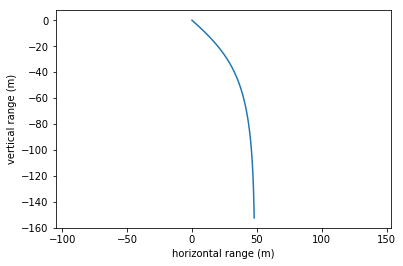

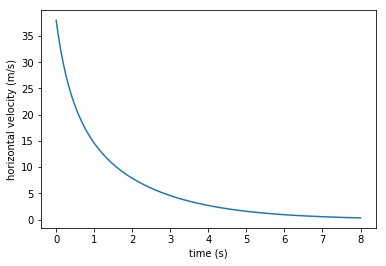

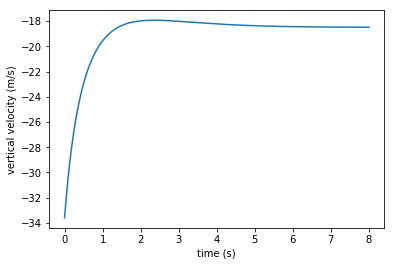

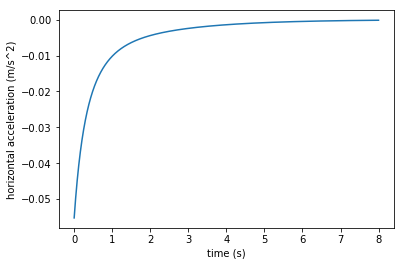

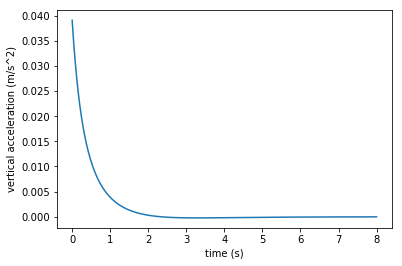

In [11]:
# break out the solutions into convenient names:
soln_d_x= [s[0] for s in soln_d]
soln_d_y= [s[1] for s in soln_d]
soln_d_z= [s[2] for s in soln_d]
soln_d_xdot= [s[3] for s in soln_d]
soln_d_ydot= [s[4] for s in soln_d]
soln_d_zdot= [s[5] for s in soln_d]
soln_d_xddot= np.diff(soln_d_xdot) # x acceleration
soln_d_yddot= np.diff(soln_d_ydot) # y acceleration
soln_d_zddot= np.diff(soln_d_zdot) # z acceleration

# plot da shiz:
plt.figure(1)
plt.plot(soln_d_x, soln_d_y)
plt.axis('equal')
plt.xlabel('horizontal range (m)')
plt.ylabel('vertical range (m)')
plt.figure(2)
plt.plot(times_d, soln_d_xdot)
plt.xlabel('time (s)')
plt.ylabel('horizontal velocity (m/s)')
plt.figure(3)
plt.plot(times_d, soln_d_ydot)
plt.xlabel('time (s)')
plt.ylabel('vertical velocity (m/s)')
plt.figure(4)
plt.plot(times_d[range(0, len(soln_d_xddot))], soln_d_xddot)
plt.xlabel('time (s)')
plt.ylabel('horizontal acceleration (m/s^2)')
plt.figure(5)
plt.plot(times_d[range(0, len(soln_d_yddot))], soln_d_yddot)
plt.xlabel('time (s)')
plt.ylabel('vertical acceleration (m/s^2)')

#### results

In [12]:
Lhe = soln_d_x[-1]
Lve = -soln_d_y[-1]
Lle = soln_d_z[-1]
te = times_d[-1]
print('horizontal distance travelled in step e:', Lhe)
print('vertical distance travelled in step e:', Lve)
print('lateral distance travelled in step e:', Lle)
print('time taken in step e:', te)

horizontal distance travelled in step e: 47.9152809828
vertical distance travelled in step e: 152.310700787
lateral distance travelled in step e: -17.473266895
time taken in step e: 8.0


#### old calculations

In [13]:
# x-direction calculations
##########################

# from usma:
# mx" + cd*x' = cd*w
####### need python help here #######
# ugh, I have to go learn how to use scipy... 1 sec -- Joe
# mx" + cd*x

## homogeneous equation mx" + rho*x' = 0 
##  characteristic equation for the homogeneous differential equation is:
## mr^2 + rho*r = 0 
## where the roots are: 
## r1 = 0, r2 = -(rho/m)
## complementary solution:
## xc = C1*e^0 + C2* e^(-(rho*t/m))

## non-homogeneous equation mx" + rho*x' = rho*w
## complete solution x = C1 + C2*e^(-(rho*t/m)) + wt

## solving for C1 and C2 using results from step d as initial conditions
## except time = 0 since we are making calculations just for this step
## i.e. x(0) = x_curr_tot and vx(0) = P
## therefore C1 =  and C2 =

# x_0 = Lha + Lhb + Lhc + Lhd
# t = 0
# vx_0 = P
# C1 = Symbol('C1')
# C2 = Symbol('C2')
# C_1 = solve(C1 + C2*math.exp(-(rho*t/m)) + w*t - x_0, C1)
# C_1

# print(C_1)
# C_2 = solve(C2*(-(rho/m)) + w - vx_0, C2)
# print(C_2)
# ## NEEEED HELLLPPP should be using piecewise to solve this
# ## copying C_1 output from just above with the C_2 value
# calc_C1 = 147.560492558936 + 586.6
# print(calc_C1)
# 
# ## therefore the complete solution is: 
# ## x = 734.1605 - 586.6*exp(-(rho*t/m)) + w*t
# 
# ## if the drogue falls for 3 seconds, then
# t = 3
# Lhe = 734.1605 - 586.6*math.exp(-(rho*t/m)) + w*t
# 
# print('horizontal distance gained = ', round(Lhe,4), 'm')
# print(' ')
# 
# # y-direction calculations
# ##########################
# 
# ## from usma
# ## characteristic equation:
# ## m*r^2 + rho*r = 0
# ## where the roots are r = 0 and r = (-b/m)
# 
# ## complete solution:
# ## y = C1 + C2*exp(-(rho*t)/m)
# ## solving for C1 and C2 using results from step d as initial conditions
# ## except time = 0 since we are making calculations just for this step
# 
# y_0 = Lva + Lvb + Lvc + Lvd
# print('y_0 = ', y_0)
# vy_0 = vd
# print('vy_0 = ',vy_0)
# t_0 = 0
# C1 = Symbol('C1')
# C2 = Symbol('C2')
# ## NEEEED HELLLPPP should be using piecewise to solve this
# # C1 equation
# C_1 = solve(C1 + C2*math.exp(-(rho*t_0/m)) - y_0, C1)
# print('C1 equation: ', C_1)
# # C2 equation/value
# C_2 = solve(C2*(-(rho/m)*math.exp(-(rho*t_0/m))) - vy_0, C2)
# print('C2 = ', C_2)
# ## copying C_1 output from just above with the C_2 value
# calc_C1 = 793.253769802079 + 62.2619406518579                   #62.2619406518579 + (0.879350749407306*793.253769802079)
# print('C1 = ', calc_C1)
# 
# # NEED HELP: need to make C_2 a number (int, float)
# ## if the drogue falls for 3 seconds, then
# t = 3
# Lve = calc_C1 + (-793.253769802079*math.exp(-(rho/m)*t))
# 
# print('vertical distance gained = ', Lve, 'm')
# 
# ## Maayybbbeee
# 
# vert_length = v*t
# print(vert_length)

### Step f - main 'chute fully deployed

If you want to justify to yourself that the main chute hits terminal velocity \[almost\] instantly, you can mess with the inputs for the numerical solution in step e.
#### Assumptions
* drag force in full effect
* skipping impulse and time to steady state
* main 'chute is a full 18' in dia.
* after payload has gone through the drogue decent, the horizontal velocity is the same as the wind speed

#### Variables
* cd = coeff. of drag [unitless]
* D = drag force = weight of payload*g [N]
* rho = density of air [kg/m^3]
* A = area of parachute [m^2]
* v_main = approx. steady state velocity of main 'chute [m/s]
* m = mass of payload [kg]
* w = wind speed [m/s]

#### calculations

In [14]:
Lvf= mainSafetyDist
# step f time = vertical distance / main terminal velocity
tf= Lvf/vt_m
# horizontal distance= wind speed * step f time
Lhf= wx*tf
Llf= wz*tf

#### results

In [15]:
print('horizontal distance travelled in step f:', Lhf, 'm')
print('vertical distance travelled in step f:', Lvf, 'm')
print('time taken in step f:', tf, 's')

horizontal distance travelled in step f: 1.0016722272e-14 m
vertical distance travelled in step f: 304.8 m
time taken in step f: 63.09148264984227 s


## Results

### totals

In [16]:
# TOTAL HORIZONTAL DISTANCE TRAVELED
X_TOT = Lha + Lhb + Lhc + Lhd + Lhe + Lhf
X_TOT_ft = X_TOT*3.28084
print('TOTAL HORIZONTAL DISTANCE TRAVELED = ', round(X_TOT,2), 'm ', ' = ', round(X_TOT_ft,2), 'ft')

# TOTAL VERTICAL DISTANCE DESCENDED
Y_TOT = Lva + Lvb + Lvc + Lvd + Lve + Lvf
Y_TOT_ft = Y_TOT*3.28084
print('TOTAL VERTICAL DISTANCE DESCENDED = ', round(Y_TOT,2), 'm ', ' = ', round(Y_TOT_ft,2), 'ft')

# TOTAL TIME FOR DESCENT
T_TOT = ta + tb + td + te + tf
# in minutes
t_tot_min = T_TOT/60
print('TOTAL TIME FOR DESCENT', round(T_TOT,2), 's = ', round(t_tot_min,2), 'min')

TOTAL HORIZONTAL DISTANCE TRAVELED =  178.1 m   =  584.33 ft
TOTAL VERTICAL DISTANCE DESCENDED =  517.72 m   =  1698.57 ft
TOTAL TIME FOR DESCENT 74.52 s =  1.24 min


### trajectories relative to drop point (aircraft coordinates)

xs: [   0.           24.26493256  100.26493256  100.26493256  130.18729412
  178.1025751   178.1025751 ]
ys: [  -0.           -2.          -34.14836781  -34.14836781  -60.61302551
 -212.92372629 -517.72372629]
zs: [   0.            0.            0.            0.            0.
  -17.47326689 -181.05875585]
note that Y is up and Z is to the right of the aircraft... because I don't want to change my code.


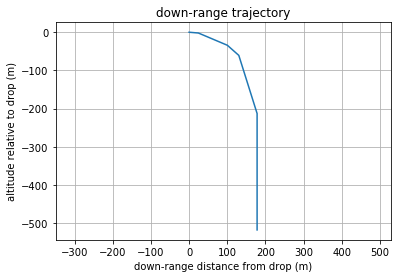

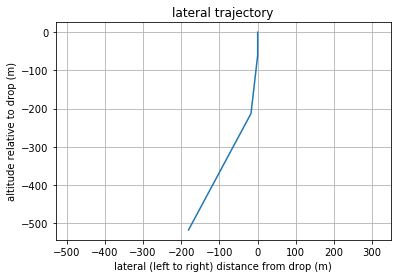

In [17]:
delta_xs=  np.array([0, Lha, Lhb, Lhc, Lhd, Lhe, Lhf])
delta_ys= -np.array([0, Lva, Lvb, Lvc, Lvd, Lve, Lvf])
delta_zs=  np.array([0, 0,   0,   0,   0,   Lle, Llf])
xs= np.cumsum(delta_xs)
ys= np.cumsum(delta_ys)
zs= np.cumsum(delta_zs)
plt.close('all')
plt.figure(1)
plt.plot(xs,ys)
_= plt.axis('equal')
plt.grid()
plt.title('down-range trajectory')
plt.xlabel('down-range distance from drop (m)')
plt.ylabel('altitude relative to drop (m)')
plt.figure(2)
plt.plot(zs, ys)
_= plt.axis('equal')
plt.grid()
plt.title('lateral trajectory')
plt.xlabel('lateral (left to right) distance from drop (m)')
plt.ylabel('altitude relative to drop (m)')

print('xs:', xs)
print('ys:', ys)
print('zs:', zs)
print('note that Y is up and Z is to the right of the aircraft... because I don\'t want to change my code.')

### trajectories relative to drop point (East-North coordinates)

Es: [   0.           17.15789836   70.89801373   70.89801373   92.0563185
  113.58207309   -2.09033545]
ys: [  -0.           -2.          -34.14836781  -34.14836781  -60.61302551
 -212.92372629 -517.72372629]
Ns: [   0.           17.15789836   70.89801373   70.89801373   92.0563185
  138.29300411  253.96541266]


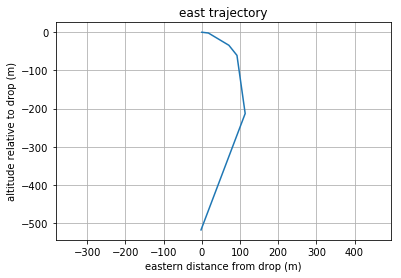

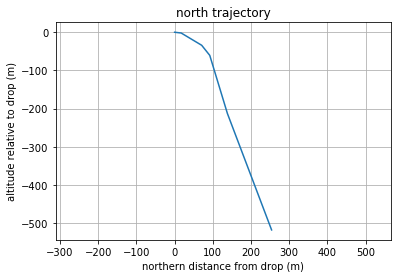

In [18]:
Es= xs*np.cos(theta_a) +zs*np.sin(theta_a)
Ns= xs*np.sin(theta_a) -zs*np.cos(theta_a) 

plt.figure(2)
plt.plot(Es,ys)
_= plt.axis('equal')
plt.grid()
plt.title('east trajectory')
plt.xlabel('eastern distance from drop (m)')
plt.ylabel('altitude relative to drop (m)')
plt.figure(3)
plt.plot(Ns, ys)
_= plt.axis('equal')
plt.grid()
plt.title('north trajectory')
plt.xlabel('northern distance from drop (m)')
plt.ylabel('altitude relative to drop (m)')

print('Es:', Es)
print('ys:', ys)
print('Ns:', Ns)